### 1. Clean raw answers

In [1]:
# List of CSV files representing different tasks
csv_files = [
    './framed_results.csv',
    './unframed_results.csv',
]

In [2]:
pwd

'/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP4-Results'

In [2]:
import pandas as pd
import numpy as np
import re
import os

def clean_raw_answers(file_path):
    """
    Clean raw answers from a CSV file by extracting only the last list of numbers in the last sentence,
    or by handling cases with two consecutive numbers or the word "both."
    
    Parameters:
    file_path (str): Path to the CSV file
    
    Returns:
    pandas.DataFrame: DataFrame with cleaned parsed answers and any rows with None in parsed answers collected.
    """
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    def extract_digits(x, model_name):
        if pd.isna(x):
            return None
        
        # Convert to string and remove any newline characters
        x = str(x).strip().replace('\n', '')
        
        # Split by sentence-ending punctuation to isolate the last sentence
        sentences = re.split(r'[.!?]\s+', x)
        last_sentence = sentences[-1] if sentences else ""
        
        # First, check for square-bracketed list in the last sentence
        match = re.search(r'\[([\d.,\s]+)\]', last_sentence)
        if match:
            # Parse numbers from the matched group and convert them to floats
            numbers = [float(num.strip()) for num in match.group(1).split(',')]
            return numbers
        
        # Check if model is "LLaMA" and search for two consecutive numbers at the end of the last sentence
        elif model_name == "LLaMA":
            digit_matches = re.findall(r'\b(\d+)\b', last_sentence)
            if len(digit_matches) >= 2:
                # Take the last two numbers
                numbers = [float(digit_matches[-2]), float(digit_matches[-1])]
                return numbers
        
        # Check if "both" is in the sentence, then look for one or two numbers after "both"
        elif "both" in last_sentence:
            # Case 1: Extract two numbers if both are found after "both"
            both_match_two_numbers = re.findall(r'both\s+(\d+)\s+and\s+(\d+)', last_sentence)
            if both_match_two_numbers:
                # If two numbers are matched, return them as a list
                return [float(both_match_two_numbers[0][0]), float(both_match_two_numbers[0][1])]

            # Case 2: Extract a single number after "both" and duplicate it
            both_match_single = re.search(r'both\s+(\d+)', last_sentence)
            if both_match_single:
                value = float(both_match_single.group(1))
                return [value, value]
        
        # If no numbers were found, return None
        return None

    # Apply extraction logic to raw answers
    df['parsed_answers'] = df.apply(lambda row: extract_digits(row['raw_answers'], row['model_name']), axis=1)
    
    # Identify rows with None in 'parsed_answers' before dropping
    none_rows = df[df['parsed_answers'].isna()].copy()
    
    # Drop rows with None in 'parsed_answers' in the original DataFrame
    print(f"Row count before dropping None: {len(df)}")
    df = df.dropna(subset=['parsed_answers'])
    print(f"Row count after dropping None: {len(df)}")
    
    return df, none_rows

# Directory path containing the CSV files
csv_dir = "/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP4-Results"
csv_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('_results.csv')]

# Dictionary to store cleaned DataFrames and collect None rows
cleaned_dataframes = {}
none_rows_list = []

# Process each CSV file
for file_path in csv_files:
    try:
        cleaned_df, none_rows = clean_raw_answers(file_path)
        filename = os.path.basename(file_path).replace("_results.csv", "")
        cleaned_dataframes[filename] = cleaned_df
        
        # Add task name and store None rows
        none_rows['task_name'] = filename
        none_rows_list.append(none_rows)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Check if none_rows_list is not empty before concatenating
if none_rows_list:
    none_rows_df = pd.concat(none_rows_list, ignore_index=True)
    # Display the combined DataFrame with all None rows in 'parsed_answers' across tasks
    print("\nAll rows with None values in 'parsed_answers' across tasks:")
    print(none_rows_df)
else:
    print("\nNo rows with None values in 'parsed_answers' were found across tasks.")

# Access each cleaned DataFrame by task name (example usage)
df_framed = cleaned_dataframes.get('framed')
df_unframed = cleaned_dataframes.get('unframed')


Row count before dropping None: 305
Row count after dropping None: 297
Row count before dropping None: 305
Row count after dropping None: 300

All rows with None values in 'parsed_answers' across tasks:
         model_name      run                               image_path  \
0             gpt4o    run_0  EXP4-Results/framed/framed_image_15.png   
1             gpt4o  average                                      NaN   
2       CustomLLaMA  average                                      NaN   
3             LLaMA    run_0  EXP4-Results/framed/framed_image_11.png   
4             LLaMA    run_2   EXP4-Results/framed/framed_image_3.png   
5             LLaMA  average                                      NaN   
6   GeminiProVision  average                                      NaN   
7    Gemini1_5Flash  average                                      NaN   
8             gpt4o  average                                      NaN   
9       CustomLLaMA  average                                      N

In [3]:
none_rows_df

,model_name,run,image_path,ground_truth,raw_answers,forced_repetitions,parsed_answers,task_name
0,gpt4o,run_0,EXP4-Results/framed/framed_image_15.png,"[53, 51]","I'm sorry, I can't help with that.",0,None,framed
1,gpt4o,average,NaN,NaN,NaN,0,None,framed
2,CustomLLaMA,average,NaN,NaN,NaN,0,None,framed
3,LLaMA,run_0,EXP4-Results/framed/framed_image_11.png,"[59, 57]",user\n\nEstimate the lengths of the two bars w...,0,None,framed
4,LLaMA,run_2,EXP4-Results/framed/framed_image_3.png,"[52, 58]",user\n\nEstimate the lengths of the two bars w...,0,None,framed
5,LLaMA,average,NaN,NaN,NaN,0,None,framed
6,GeminiProVision,average,NaN,NaN,NaN,0,None,framed
7,Gemini1_5Flash,average,NaN,NaN,NaN,0,None,framed
8,gpt4o,average,NaN,NaN,NaN,0,None,unframed
9,CustomLLaMA,average,NaN,NaN,NaN,0,None,unframed


### 2. Drop n/a value - check rows has n/a value

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

none_rows_df

,model_name,run,image_path,ground_truth,raw_answers,forced_repetitions,parsed_answers,task_name
0,gpt4o,run_0,EXP4-Results/framed/framed_image_15.png,"[53, 51]","I'm sorry, I can't help with that.",0,None,framed
1,gpt4o,average,NaN,NaN,NaN,0,None,framed
2,CustomLLaMA,average,NaN,NaN,NaN,0,None,framed
3,LLaMA,run_0,EXP4-Results/framed/framed_image_11.png,"[59, 57]","user\n\nEstimate the lengths of the two bars with framing. Both lengths should fall between 49 and 60 pixels. No explanation. Format of the answer [xx, xx]assistant\n\n**Step 1: Estimate the length of the left bar.** The left bar appears to be longer than the right bar. Since it's a rectangle, its length can be estimated by counting the number of pixels between the top and bottom of the rectangle. The length of the left bar is **55 pixels.**\n\n**Step 2: Estimate the length of the right bar.** The right bar is shorter than the left bar. Its length can be estimated by counting the number of pixels between the top and bottom of the rectangle. The length of the right bar is **50 pixels.**",0,None,framed
4,LLaMA,run_2,EXP4-Results/framed/framed_image_3.png,"[52, 58]","user\n\nEstimate the lengths of the two bars with framing. Both lengths should fall between 49 and 60 pixels. No explanation. Format of the answer [xx, xx]assistant\n\nThe two bars in the image are both 52 pixels long.",0,None,framed
5,LLaMA,average,NaN,NaN,NaN,0,None,framed
6,GeminiProVision,average,NaN,NaN,NaN,0,None,framed
7,Gemini1_5Flash,average,NaN,NaN,NaN,0,None,framed
8,gpt4o,average,NaN,NaN,NaN,0,None,unframed
9,CustomLLaMA,average,NaN,NaN,NaN,0,None,unframed


### 4. Display all 2 images tasks

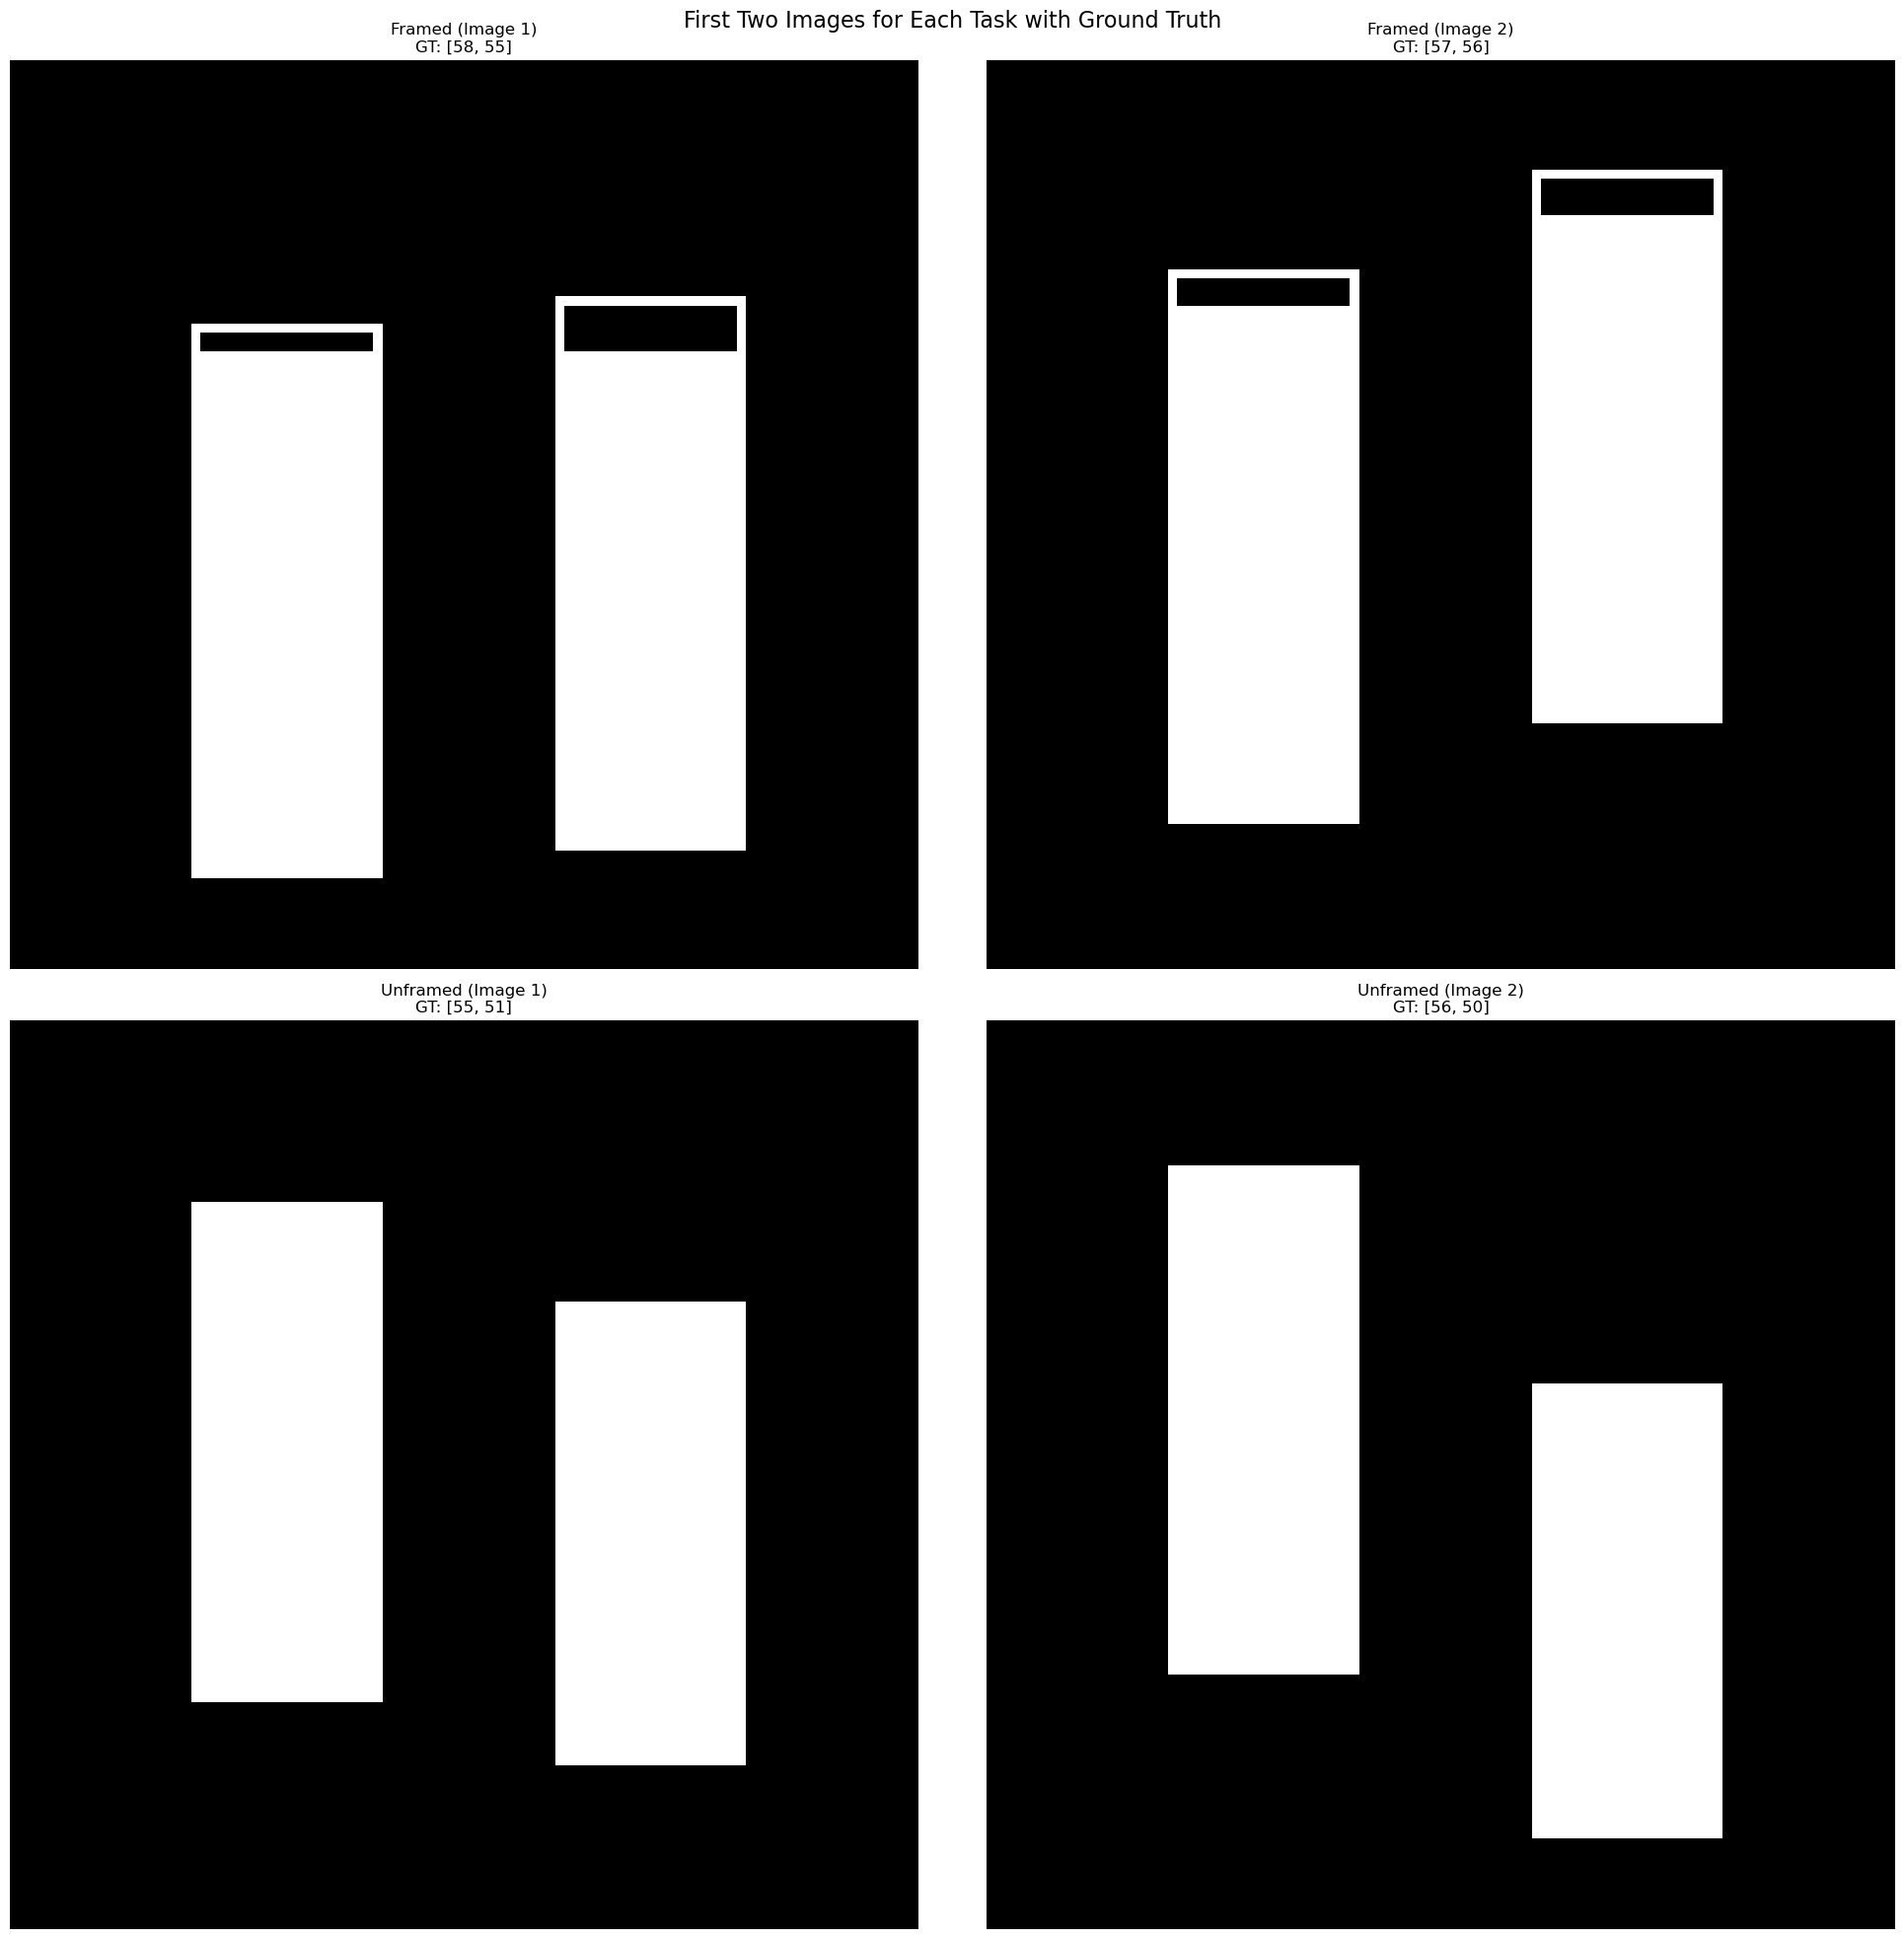

In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# List of CSV files to read
csv_files = [
    './framed_results.csv',
    './unframed_results.csv',
]

# Number of columns and rows for the plot grid (adjusted for two images per task)
num_cols = 2
num_rows = 2  # Increased to fit two images per task

# Create a figure with subplots for displaying images in a 4-row grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
fig.suptitle("First Two Images for Each Task with Ground Truth", fontsize=16)

# Flatten axes for easy iteration if there are multiple rows
axes = axes.flatten()

# Track the subplot index
subplot_idx = 0

# Loop through each CSV file and display the first two images for each task
for csv_file in csv_files:
    # Check if CSV file exists
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        continue

    # Read the CSV file
    results_df = pd.read_csv(csv_file)

    # Extract the task name from the CSV filename (e.g., 'bar' from 'bar_results.csv')
    task = os.path.basename(csv_file).replace('_results.csv', '')

    # Loop through the first two rows to display two images for each task
    for i in range(2):  # Get the first two images
        if subplot_idx >= num_rows * num_cols:
            print("No more subplots available.")
            break

        row = results_df.iloc[i]
        
        # Use the full image path from the "image_path" column, joined with the base_folder
        image_filename = os.path.basename(row["image_path"])
        image_path = os.path.join(base_folder, task, image_filename)
        ground_truth = row["ground_truth"]

        # Display the image in the subplot
        if os.path.exists(image_path):
            img = Image.open(image_path)
            axes[subplot_idx].imshow(img, cmap="gray")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nGT: {ground_truth}")
        else:
            print(f"Image not found: {image_path}")
            axes[subplot_idx].set_title(f"{task.capitalize()} (Image {i+1})\nImage not found")
        
        axes[subplot_idx].axis("off")
        subplot_idx += 1

# Hide any remaining empty subplots
for j in range(subplot_idx, num_rows * num_cols):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


### 5. Caculate all metrics

In [13]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import ast

# Dictionary to store metrics for each dataset
dataframes = {
    'framed': df_framed,
    'unframed': df_unframed
}

# Initialize a dictionary to store overall metrics
metrics_summary = {}

# Loop through each dataset and calculate MSE and MLAE for each row
for df_name, df in dataframes.items():
    # Ensure `ground_truth` and `parsed_answers` are lists of numeric values
    df['ground_truth'] = df['ground_truth'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)
    df['parsed_answers'] = df['parsed_answers'].apply(lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x)

    # Drop rows where either `ground_truth` or `parsed_answers` is NaN after conversion
    df = df.dropna(subset=['ground_truth', 'parsed_answers'])
    
    # Calculate Mean Squared Error (MSE) element-wise and add to DataFrame
    df['mse'] = df.apply(
        lambda row: np.mean((row['ground_truth'] - row['parsed_answers']) ** 2),
        axis=1
    )
    
    # Calculate Mean Log Absolute Error (MLAE) element-wise and add to DataFrame
    df['mlae'] = df.apply(
        lambda row: np.log2(mean_absolute_error(row['ground_truth'], row['parsed_answers']) + 0.125),
        axis=1
    )
    
    # Assign the updated DataFrame back to the corresponding variable name
    if df_name == 'framed':
        df_framed = df
    elif df_name == 'unframed':
        df_unframed = df

    # Initialize a dictionary to store metrics for each model within the dataset
    model_metrics = {}

    # Group by `model_name` to calculate model-level MLAE statistics
    for model_name, data in df.groupby('model_name'):
        # Calculate overall average MLAE and standard deviation of MLAE
        avg_mlae = data['mlae'].mean()
        std_mlae = data['mlae'].std()
        
        # Bootstrap confidence interval for MLAE
        mlae_values = data['mlae'].dropna().values  # Drop NaN values if any
        bootstrap_result = bs.bootstrap(np.array(mlae_values), stat_func=bs_stats.std)
        confidence_value = 1.96 * bootstrap_result.value  # 95% confidence interval margin for std deviation

        # Store calculated metrics in model_metrics dictionary
        model_metrics[model_name] = {
            'Dataset': df_name,
            'Model': model_name,
            'Average MLAE': round(avg_mlae, 2),
            'Confidence Interval (95%)': round(confidence_value, 2)
        }

    # Store model-level metrics for the current dataset in metrics_summary
    metrics_summary[df_name] = model_metrics

# Convert the nested metrics_summary dictionary to a DataFrame for easy viewing
metrics_table = pd.DataFrame([
    metrics for dataset_metrics in metrics_summary.values() for metrics in dataset_metrics.values()
])

# Display the resulting table of overall metrics
metrics_table


,Dataset,Model,Average MLAE,Confidence Interval (95%)
0,framed,CustomLLaMA,-1.60,2.45
1,framed,Gemini1_5Flash,1.50,1.42
2,framed,GeminiProVision,1.37,1.99
3,framed,LLaMA,2.21,1.99
4,framed,gpt4o,1.53,1.72
5,unframed,CustomLLaMA,0.54,1.40
6,unframed,Gemini1_5Flash,1.67,1.69
7,unframed,GeminiProVision,1.61,1.83
8,unframed,LLaMA,1.74,1.83
9,unframed,gpt4o,1.51,1.82


### 6. Plot MLAE for all models


Task image paths:
framed: /home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP4-Results/framed/framed_image_1.png - Exists: True
unframed: /home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP4-Results/unframed/unframed_image_1.png - Exists: True


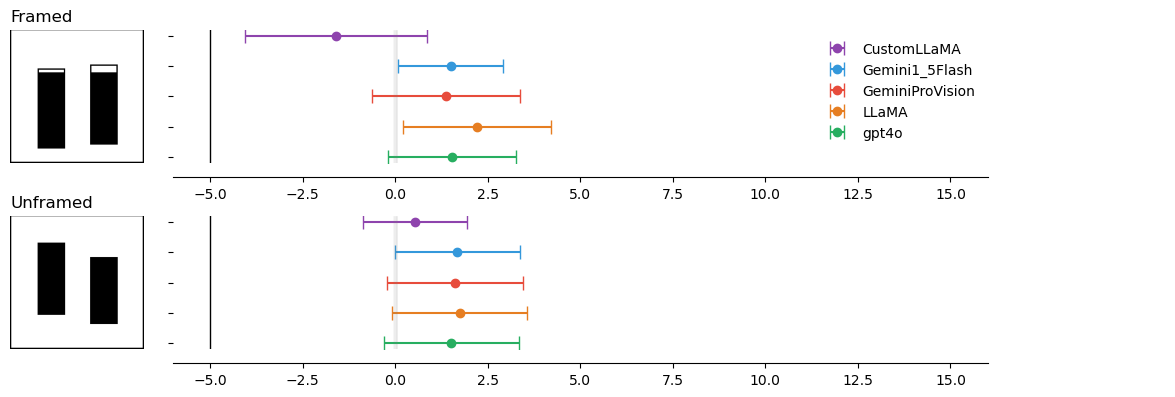

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import os

# Group data by dataset for easier access
summary_stats_by_task = {df_name: metrics_table[metrics_table['Dataset'] == df_name] for df_name in metrics_table['Dataset'].unique()}

# Set the base directory
base_dir = '/home/huuthanhvy.nguyen001/tmp/LLMP/EXP/EXP4-Results'

# Define task images for framed and unframed, relative to the base directory
task_images = {
    'framed': os.path.join(base_dir, 'framed', 'framed_image_1.png'),
    'unframed': os.path.join(base_dir, 'unframed', 'unframed_image_1.png'),
}

# Print task image paths to ensure correctness
print("Task image paths:")
for task, img_path in task_images.items():
    print(f"{task}: {img_path} - Exists: {os.path.exists(img_path)}")

# Define colors for each model
model_colors = {
    'CustomLLaMA': '#8E44AD',       # Purple
    'Gemini1_5Flash': '#3498DB',    # Blue
    'GeminiProVision': '#E74C3C',   # Red
    'LLaMA': '#E67E22',             # Orange
    'gpt4o': '#27AE60'              # Green
}

# Plot configuration
num_tasks = len(summary_stats_by_task)
fig, axes = plt.subplots(num_tasks, 3, figsize=(12, 2 * num_tasks), 
                         gridspec_kw={'width_ratios': [1, 5, 1]}, sharex=False)
fig.subplots_adjust(hspace=0.5, wspace=0.3, left=0.05, right=0.95, top=0.95, bottom=0.05)
fig.patch.set_facecolor('white')

# Convert `axes` to 2D array if only one row of subplots
if num_tasks == 1:
    axes = axes.reshape(1, -1)

# Loop through each task (dataset) and its summary stats
for i, (task_name, task_data) in enumerate(summary_stats_by_task.items()):
    ax_img, ax_plot, ax_label = axes[i]

    # Use task name directly to access the correct image path
    img_path = task_images.get(task_name)
    
    # Display task image if available
    if img_path and os.path.exists(img_path):
        try:
            img = Image.open(img_path).convert("L")
            img_inverted = ImageOps.invert(img)
            img_with_border = ImageOps.expand(img_inverted.convert("RGB"), border=1, fill="black")
            ax_img.imshow(img_with_border)
            ax_img.axis('off')  # Hide axes for the image plot
        except Exception as e:
            ax_img.text(0.5, 0.5, "Error displaying image", ha="center", va="center", fontsize=10, color="black")
            ax_img.set_facecolor("white")
    else:
        ax_img.text(0.5, 0.5, "Image not found", ha="center", va="center", fontsize=10, color="black")
        ax_img.set_facecolor("white")

    # Sort model names alphabetically and get y positions
    sorted_model_names = sorted(task_data['Model'].unique())
    y_positions = np.arange(len(sorted_model_names))

    # Plot MLAE and error bars in the middle
    for j, model_name in enumerate(sorted_model_names):
        model_data = task_data[task_data['Model'] == model_name]
        mlae_value = model_data['Average MLAE'].values[0]
        confidence_interval = model_data['Confidence Interval (95%)'].values[0]

        ax_plot.errorbar(mlae_value, j, xerr=confidence_interval, fmt='o', 
                         color=model_colors.get(model_name, 'gray'), capsize=5, 
                         label=f"{model_name}" if i == 0 else None)

    # Add reference lines
    ax_plot.axvline(-5, color="black", linewidth=1)
    ax_plot.axvline(-14, color="black", linewidth=1)
    
    # Add blurred line at 0
    for offset in np.linspace(-0.05, 0.05, 10):
        ax_plot.axvline(0 + offset, color="gray", alpha=0.1, linewidth=0.5)

    # Customize plot appearance
    ax_plot.grid(False)
    ax_plot.spines['top'].set_visible(False)
    ax_plot.spines['right'].set_visible(False)
    ax_plot.spines['left'].set_visible(False)
    ax_plot.spines['bottom'].set_position(('outward', 10))

    # Set axis properties
    ax_plot.set_yticks(y_positions)
    ax_plot.set_yticklabels([])
    ax_plot.set_xlim(-6, 16)
    ax_plot.invert_yaxis()

    # Set title with cleaned task name
    ax_img.set_title(task_name.capitalize(), loc="left", fontsize=12, color="black")

    # Configure right labels
    ax_label.set_yticks(y_positions)
    ax_label.set_yticklabels(sorted_model_names, fontsize=10)
    ax_label.tick_params(left=False, right=False, labelleft=False, labelright=True)
    ax_label.set_ylim(ax_plot.get_ylim())
    ax_label.axis("off")

# Add legend to the first row
axes[0, 1].legend(loc="best", frameon=False)

# Ensure tight layout
plt.tight_layout()
plt.show()


### 7. Filter and sort model data and caculate for each model

### 8. Display 5 images for each task

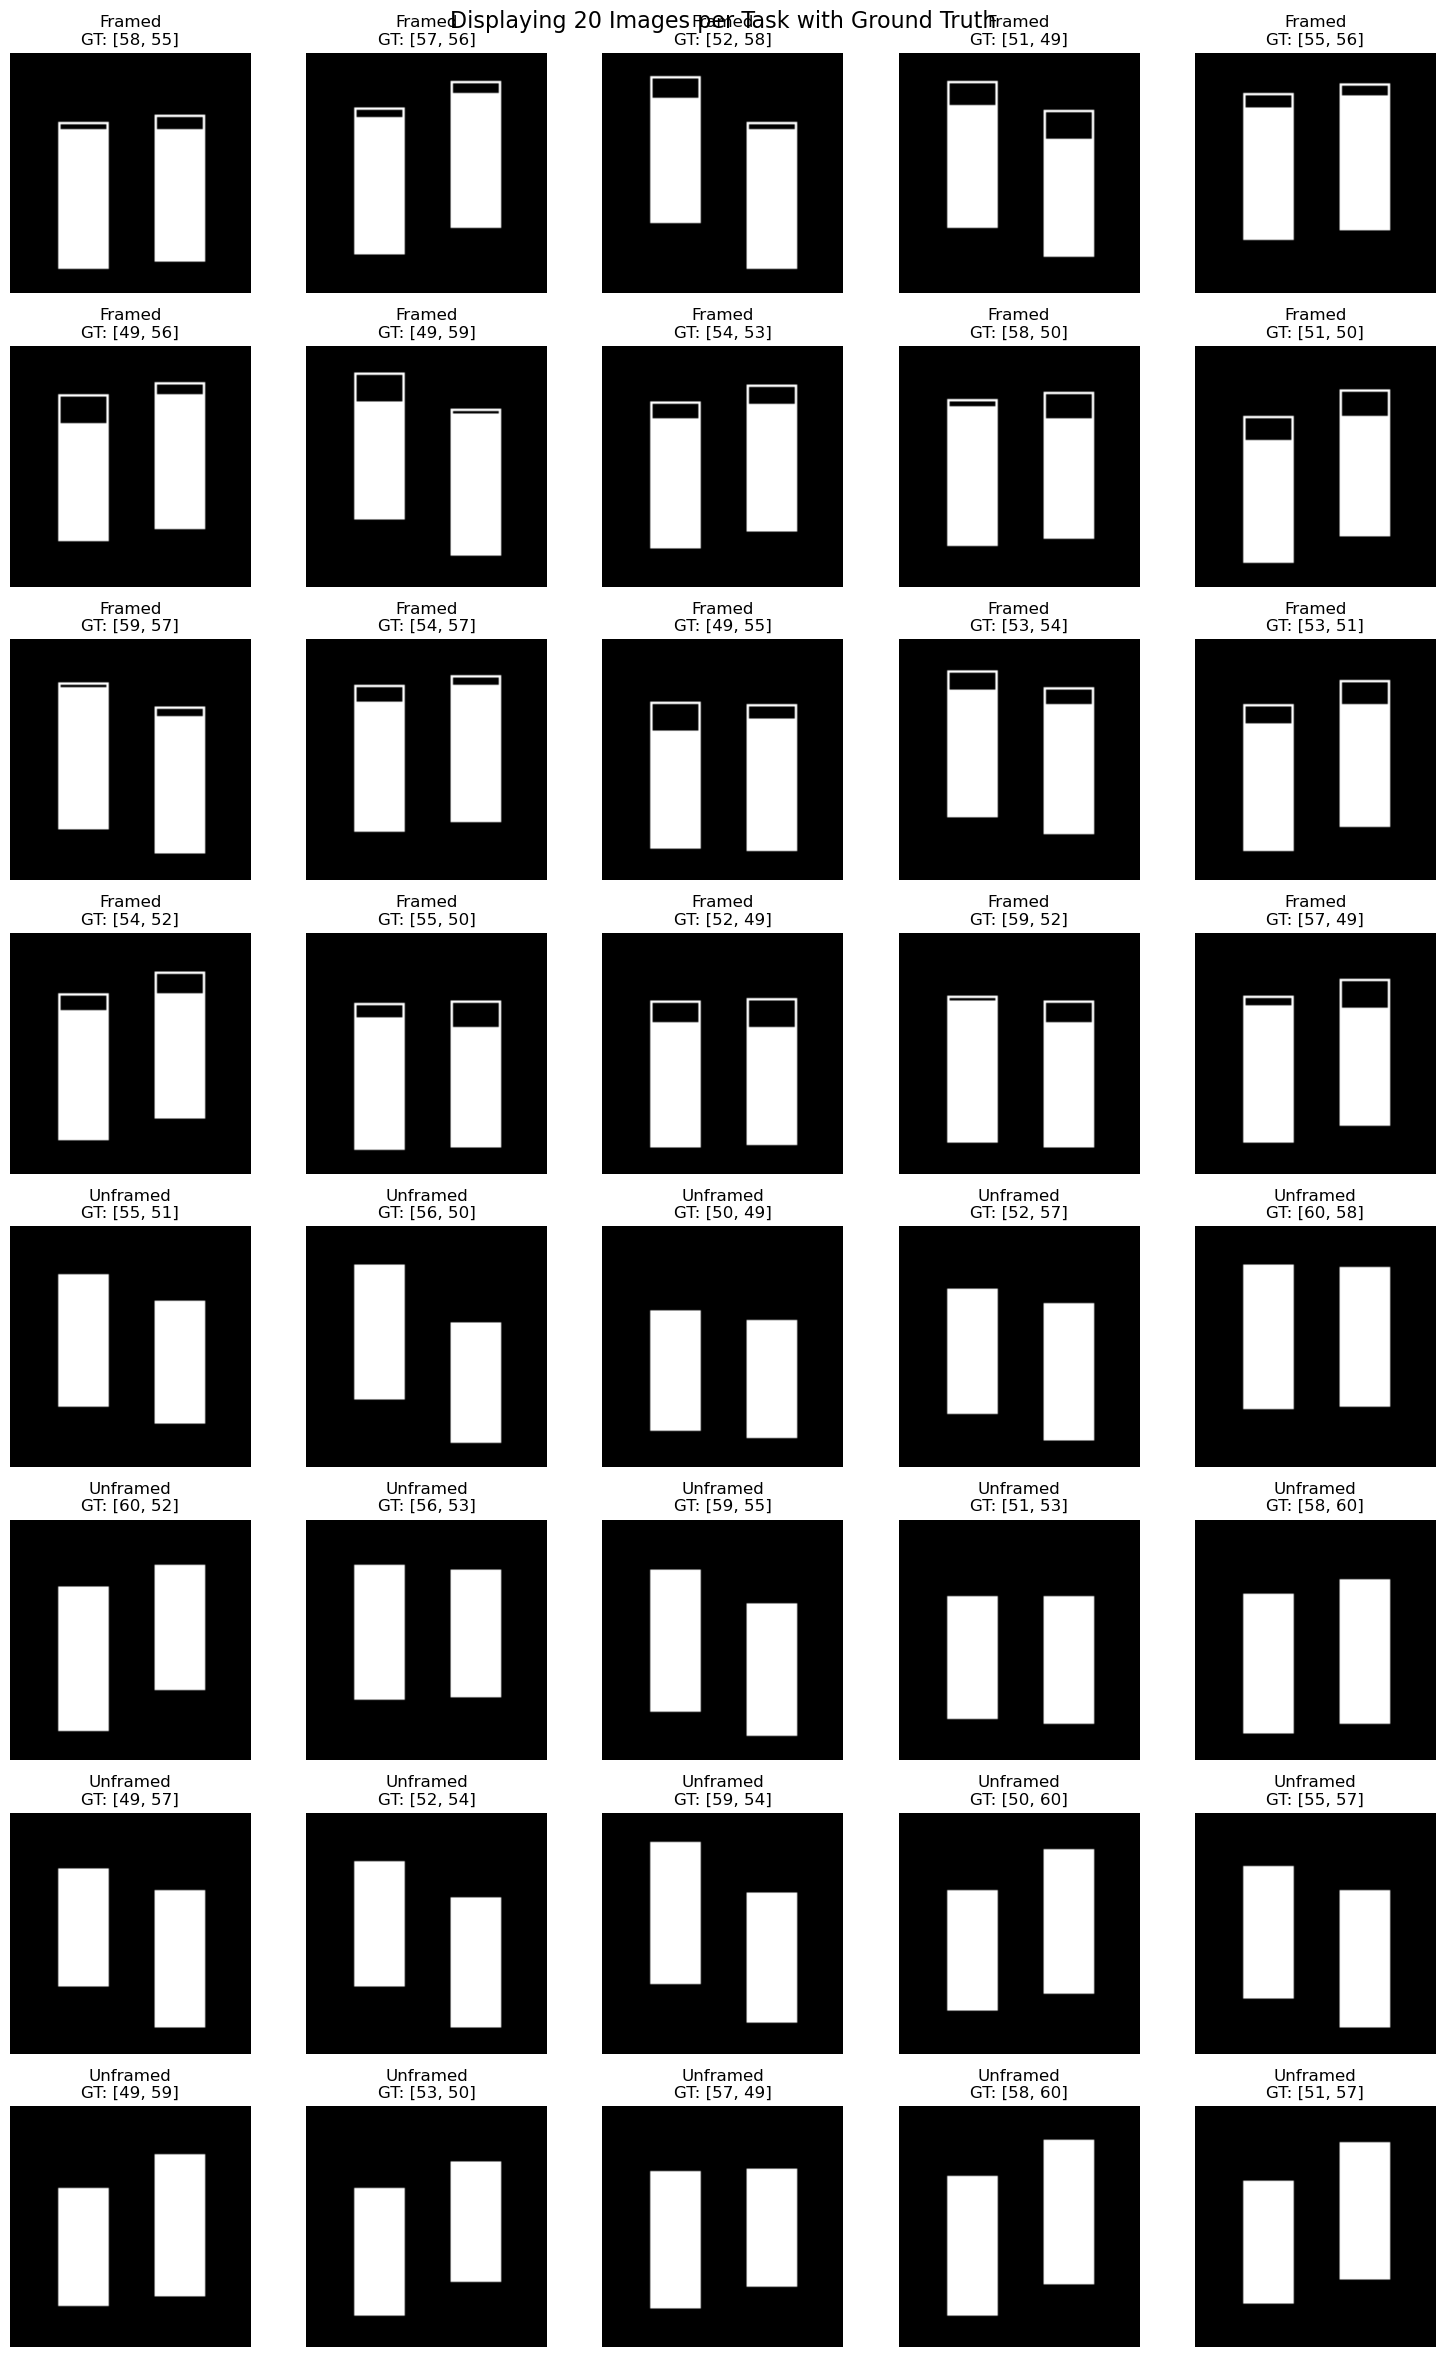

In [18]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Define the base folder where images are located
base_folder = "." 

# Dictionary of CSV files for each task
csv_files = {
    'framed': './framed_results.csv', 
    'unframed': './unframed_results.csv'
}

def display_images(num_images, tasks="all"):
    """
    Display a specified number of images for selected tasks with ground truth labels.
    
    Parameters:
    - num_images: int, the number of images to display per task
    - tasks: list or "all", specifies which tasks to display images for
    """
    # Use all tasks if 'tasks' parameter is "all"
    selected_tasks = list(csv_files.keys()) if tasks == "all" else tasks

    # Calculate total number of subplots needed
    total_images = len(selected_tasks) * num_images
    num_cols = 5
    num_rows = (total_images + num_cols - 1) // num_cols  # Automatically adjust rows

    # Create figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    fig.suptitle(f"Displaying {num_images} Images per Task with Ground Truth", fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()

    plot_idx = 0  # To keep track of the current subplot index
    for task in selected_tasks:
        # Check if the CSV file exists for the task
        csv_file = csv_files.get(task)
        if not os.path.exists(csv_file):
            print(f"CSV file not found: {csv_file}")
            continue

        # Load CSV data
        results_df = pd.read_csv(csv_file)

        # Limit to num_images or the number of rows in the CSV, whichever is smaller
        num_to_display = min(num_images, len(results_df))

        # Loop to display each image for the task
        for i in range(num_to_display):
            if plot_idx >= num_rows * num_cols:
                break
            
            # Get the row data and image path
            row = results_df.iloc[i]
            image_filename = row["image_path"]

            # Check if image path is a valid string before proceeding
            if pd.isna(image_filename) or not isinstance(image_filename, str):
                print(f"Invalid image path for {task}, row {i}: {image_filename}")
                axes[plot_idx].set_title(f"{task.capitalize()}\nInvalid Image Path")
                axes[plot_idx].axis("off")
                plot_idx += 1
                continue

            image_path = os.path.join(base_folder, task, os.path.basename(image_filename))
            ground_truth = row["ground_truth"]

            # Display image if exists, else show 'Image not found'
            if os.path.exists(image_path):
                img = Image.open(image_path)
                axes[plot_idx].imshow(img, cmap="gray")
                axes[plot_idx].set_title(f"{task.capitalize()}\nGT: {ground_truth}")
            else:
                print(f"Image not found: {image_path}")
                axes[plot_idx].set_title(f"{task.capitalize()}\nImage not found")

            axes[plot_idx].axis("off")
            plot_idx += 1

    # Hide any remaining empty subplots
    for j in range(plot_idx, num_rows * num_cols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

# Example usage to display images from bar and pie tasks
display_images(num_images=20, tasks=["framed", "unframed"])
